<a href="https://colab.research.google.com/github/isaacd68/MAT494-data-science/blob/main/3_3CalculusandOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nelder-Mead Simplex algorithm (method='Nelder-Mead')**



the minimize routine is used with the Nelder-Mead simplex algorithm (selected through the method parameter):

In [4]:
import numpy as np
from scipy.optimize import minimize
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571


In [5]:
print(res.x)

[1. 1. 1. 1. 1.]


The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

Another optimization algorithm that needs only function calls to find the minimum is Powell’s method available by setting method='powell' in minimize.

# **Broyden-Fletcher-Goldfarb-Shanno algorithm (method='BFGS')**

In order to converge more quickly to the solution, this routine uses the gradient of the objective function. If the gradient is not given by the user, then it is estimated using first-differences. The Broyden-Fletcher-Goldfarb-Shanno (BFGS) method typically requires fewer function calls than the simplex algorithm even when the gradient must be estimated.

In [6]:
def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [7]:
res = minimize(rosen, x0, method='BFGS', jac=rosen_der,
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30


In [8]:
res.x

array([1.00000004, 1.0000001 , 1.00000021, 1.00000044, 1.00000092])

# **Newton-Conjugate-Gradient algorithm (method='Newton-CG')**

Newton-Conjugate Gradient algorithm is a modified Newton’s method and uses a conjugate gradient algorithm to (approximately) invert the local Hessian. 

The inverse of the Hessian is evaluated using the conjugate-gradient method. An example of employing this method to minimizing the Rosenbrock function is given below. To take full advantage of the Newton-CG method, a function which computes the Hessian must be provided. The Hessian matrix itself does not need to be constructed, only a vector which is the product of the Hessian with an arbitrary vector needs to be available to the minimization routine. As a result, the user can provide either a function to compute the Hessian matrix, or a function to compute the product of the Hessian with an arbitrary vector.

# Hessian example

In [9]:
def rosen_hess(x):
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

In [10]:
res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hess=rosen_hess,
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 24


In [11]:
res.x

array([1.        , 1.        , 1.        , 0.99999999, 0.99999999])

# Hessian product example:

For larger minimization problems, storing the entire Hessian matrix can consume considerable time and memory. The Newton-CG algorithm only needs the product of the Hessian times an arbitrary vector. As a result, the user can supply code to compute this product rather than the full Hessian by giving a hess function which take the minimization vector as the first argument and the arbitrary vector as the second argument (along with extra arguments passed to the function to be minimized). If possible, using Newton-CG with the Hessian product option is probably the fastest way to minimize the function.

In [12]:
def rosen_hess_p(x, p):
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1] \
               -400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

In [13]:
res = minimize(rosen, x0, method='Newton-CG',
               jac=rosen_der, hessp=rosen_hess_p,
               options={'xtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 56
         Hessian evaluations: 66


In [14]:
res.x

array([1.        , 1.        , 1.        , 0.99999999, 0.99999999])

# **Trust-Region Nearly Exact Algorithm (method='trust-exact')**

All methods Newton-CG, trust-ncg and trust-krylov are suitable for dealing with large-scale problems (problems with thousands of variables). That is because the conjugate gradient algorithm approximately solve the trust-region subproblem (or invert the Hessian) by iterations without the explicit Hessian factorization. Since only the product of the Hessian with an arbitrary vector is needed, the algorithm is specially suited for dealing with sparse Hessians, allowing low storage requirements and significant time savings for those sparse problems.

For medium-size problems, for which the storage and factorization cost of the Hessian are not critical, it is possible to obtain a solution within fewer iteration by solving the trust-region subproblems almost exactly. To achieve that, a certain nonlinear equations is solved iteratively for each quadratic subproblem [CGT]. This solution requires usually 3 or 4 Cholesky factorizations of the Hessian matrix. As the result, the method converges in fewer number of iterations and takes fewer evaluations of the objective function than the other implemented trust-region methods. The Hessian product option is not supported by this algorithm. An example using the Rosenbrock function follows:

In [15]:
res = minimize(rosen, x0, method='trust-exact',
               jac=rosen_der, hess=rosen_hess,
               options={'gtol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 13
         Hessian evaluations: 14


In [16]:
res.x

array([1., 1., 1., 1., 1.])

# **Global optimization**

Global optimization aims to find the global minimum of a function within given bounds, in the presence of potentially many local minima. Typically, global minimizers efficiently search the parameter space, while using a local minimizer (e.g., minimize) under the hood. SciPy contains a number of good global optimizers. Here, we’ll use those on the same objective function, namely the (aptly named) eggholder function:

In [17]:
def eggholder(x):
     return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
            -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

bounds = [(-512, 512), (-512, 512)]

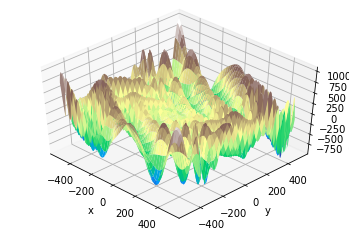

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('eggholder(x, y)')
plt.show()

We now use the global optimizers to obtain the minimum and the function value at the minimum. We’ll store the results in a dictionary so we can compare different optimization results later.

In [20]:
from scipy import optimize
results = dict()
results['shgo'] = optimize.shgo(eggholder, bounds)
results['shgo']

     fun: -935.3379515605128
    funl: array([-935.33795156])
 message: 'Optimization terminated successfully.'
    nfev: 55
     nit: 2
   nlfev: 50
   nlhev: 0
   nljev: 10
 success: True
       x: array([439.48097806, 453.97741934])
      xl: array([[439.48097806, 453.97741934]])

In [21]:
results['DA'] = optimize.dual_annealing(eggholder, bounds)
results['DA']

     fun: -956.9182316239512
 message: ['Maximum number of iteration reached']
    nfev: 4127
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([482.3532488 , 432.87893739])

All optimizers return an OptimizeResult, which in addition to the solution contains information on the number of function evaluations, whether the optimization was successful, and more. For brevity, we won’t show the full output of the other optimizers:

In [22]:
results['DE'] = optimize.differential_evolution(eggholder, bounds)
results['BH'] = optimize.basinhopping(eggholder, bounds)


shgo has a second method, which returns all local minima rather than only what it thinks is the global minimum:

In [23]:
results['shgo_sobol'] = optimize.shgo(eggholder, bounds, n=200, iters=5,
                                      sampling_method='sobol')

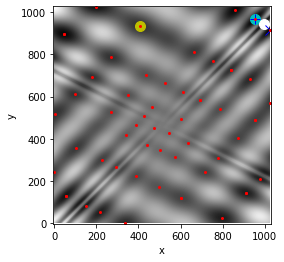

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(eggholder(xy), interpolation='bilinear', origin='lower',
                cmap='gray')
ax.set_xlabel('x')
ax.set_ylabel('y')

def plot_point(res, marker='o', color=None):
     ax.plot(512+res.x[0], 512+res.x[1], marker=marker, color=color, ms=10)

plot_point(results['BH'], color='y')  # basinhopping           - yellow
plot_point(results['DE'], color='c')  # differential_evolution - cyan
plot_point(results['DA'], color='w')  # dual_annealing.        - white

# SHGO produces multiple minima, plot them all (with a smaller marker size)
plot_point(results['shgo'], color='b', marker='+')
plot_point(results['shgo_sobol'], color='b', marker='x')
for i in range(results['shgo_sobol'].xl.shape[0]):
     ax.plot(512 + results['shgo_sobol'].xl[i, 0],
             512 + results['shgo_sobol'].xl[i, 1],
             'ro', ms=2)

ax.set_xlim([-4, 514*2])
ax.set_ylim([-4, 514*2])
plt.show()